In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm 

import os
import re
from AutoEncoder_exp import set_seed, batch_psnr
from datasets import getMNIST, getFashionMNIST, getCifar10, getDataset
import copy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
noValSamples = 10
dataset="FashionMNIST" #or: Cifar10, FashionMNIST
latent_dim = 10 # size of latent space: MLPAE, ConvAE, DeepFluidsConvAE, BetaVAE

In [4]:
from datasets import getDataset
from regularisers import computeC1Loss

In [5]:
#### some utility functions
def plotReconstruction(model, dataset, kind):
    train_loader, test_loader, noChannels, dx, dy = getDataset(dataset)
    batch_x = next(iter(train_loader))[0]
    reconstruction = model(batch_x.to(device))
    reconstruction = reconstruction.view(batch_x.shape)
    psnr = batch_psnr(reconstruction, batch_x.to(device))
    fig = plt.figure(figsize=(10,5))
    for i in range(32):
        plt.subplot(4,8,i+1)
        img = reconstruction.detach().cpu().numpy()[i].reshape(noChannels,dx,dy)
        plt.imshow(np.moveaxis(img,0,2).squeeze())
        plt.axis('off')
    plt.tight_layout()
    plt.text(0.02, -0.05, "PSNR: %.4f" % (psnr), fontsize=14, transform=plt.gcf().transFigure)
    plt.savefig('./output/plotReconstruction' + kind +'.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
    plt.show()
    print("PSNR: %.4f" % (psnr))
    
def plotJacobian(model, device, kind):
    torch.manual_seed(4242)
    Jac_val_pts = torch.FloatTensor(  np.random.uniform(-1,1,size=(noValSamples, latent_dim))   ).to(device)
    _, Jac = computeC1Loss(Jac_val_pts, model, device)
    magicNo, _, _, _ = Jac.shape
    Jac_m = torch.mean(Jac, axis=[0,2]) * magicNo
    rank_Jacm = float(torch.matrix_rank(Jac_m).cpu().detach().numpy())
    cond_Jacm = np.linalg.cond(Jac_m.detach().cpu().numpy())
    print("Rank %d Cond %.1e" % (rank_Jacm, cond_Jacm))
    
    plt.imshow(Jac_m.squeeze().detach().cpu())
    plt.title('mu(Jacobian)')
    plt.colorbar()
    plt.text(0.35, -0.05, "Rank %d Cond %.1e" % (rank_Jacm, cond_Jacm), fontsize=14, transform=plt.gcf().transFigure)
    plt.savefig('./output/plotJacobian' + kind +'.png', dpi=300, bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
    plt.show()
    plt.close()

In [9]:
base_ae = onnx.load('./model.onnx')
regularized_ae = onnx.load('./model_reg.onnx')

NameError: name 'onnx' is not defined

In [10]:
loss_arr_reg = torch.load('./output/loss_arr_reg.pt')
loss_arr_reco = torch.load('./output/loss_arr_reco.pt')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

The following figures are showing the Jacobian and reconstructions of the **regularized autoencoder**:

In [11]:
plotReconstruction(regularized_ae, dataset, 'reg_ae')
plotJacobian(regularized_ae, device, 'reg_ae')

NameError: name 'regularized_ae' is not defined

The following figures are showing the Jacobian and reconstructions of the **baseline autoencoder**:

In [12]:
plotReconstruction(base_ae, dataset, 'base_ae')
plotJacobian(base_ae, device, 'base_ae')

NameError: name 'base_ae' is not defined

NameError: name 'loss_arr_reg' is not defined

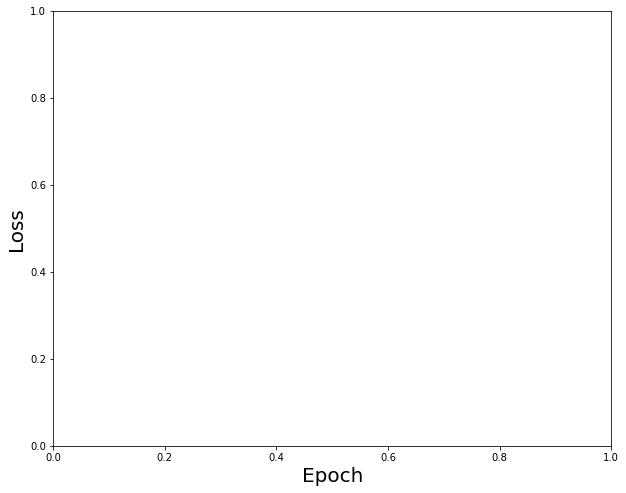

In [13]:
fig = plt.figure(1, figsize=[10, 8])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.plot(loss_arr_reg, label='Reco + C1loss for regularised AE')
plt.tick_params(axis='y', labelsize='large')
plt.tick_params(axis='x', labelsize='large')
plt.title('Total Loss rAE', fontsize=22, fontweight="bold")
plt.legend()
plt.savefig('./output/TotalLoss.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
plt.show()
plt.close()

NameError: name 'loss_arr_reco' is not defined

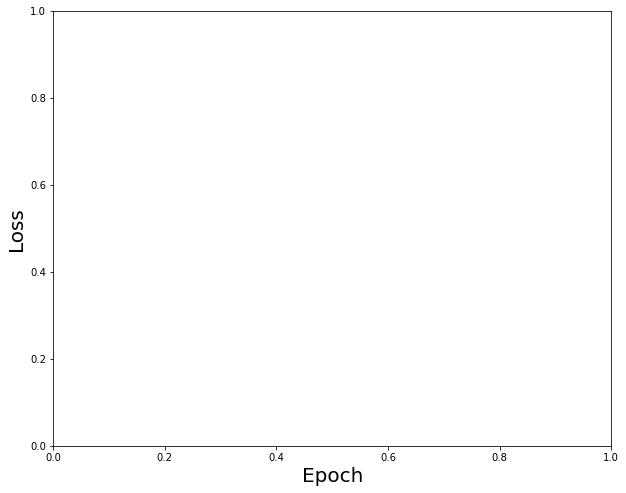

In [14]:
fig = plt.figure(1, figsize=[10, 8])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.plot(loss_arr_reco, label='Reco loss for regularised AE')
plt.tick_params(axis='y', labelsize='large')
plt.tick_params(axis='x', labelsize='large')
plt.title('Reconstruction Loss rAE', fontsize=22, fontweight="bold")
plt.legend()
plt.savefig('./output/ReconstructionLoss.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
plt.show()
plt.close()

NameError: name 'loss_arr_reg' is not defined

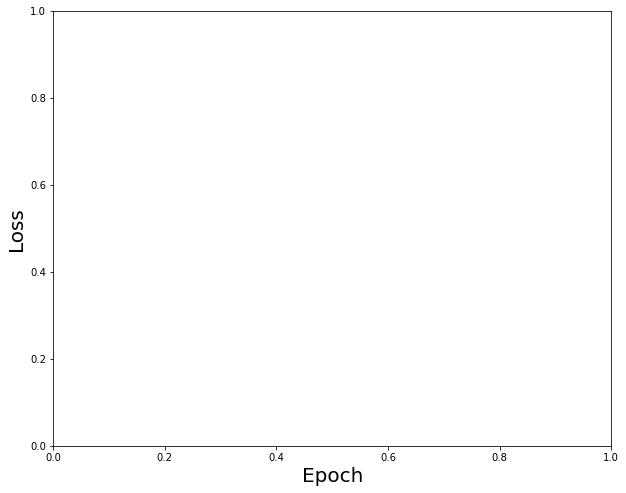

In [15]:
fig = plt.figure(1, figsize=[10, 8])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.plot(torch.sub(torch.FloatTensor(loss_arr_reg), torch.FloatTensor(loss_arr_reco)), label='C1loss for regularised AE')
plt.tick_params(axis='y', labelsize='large')
plt.tick_params(axis='x', labelsize='large')
plt.title('C1 Loss rAE', fontsize=22, fontweight="bold")
plt.legend()
plt.savefig('./output/C1Loss.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
plt.show()
plt.close()